# Imports

In [1]:
import numpy as np
from ase.io import read, write

import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms

from ltau_ff.utils import logs_to_pdfs
from ltau_ff.uq_estimator import UQEstimator
from ltau_ff.ase_wrapper import NequIPUQWrapper

# Data loading

In [2]:
error_traj = np.load('./error_traj_downsampled_GAP20.npy')  # (num_epochs, num_atoms)

bins = np.logspace(-8, np.log10(error_traj.max()), 101)  # [1e-8, max_error] are reasonable bounds for the PDFs
pdfs, bins = logs_to_pdfs([error_traj], bins=bins)  # expects list of trajectories

In [3]:
descriptors = np.load('../paper_data/descriptors_GAP20.npy')
descriptors.shape

(360027, 32)

# Prepare estimator

In [4]:
estimator = UQEstimator(
    pdfs,                        # pre-computed, possibly from loss trajectory analysis
    bins,                        # bin edges matching `pdfs`
    descriptors,                 # either static or learned descriptors
    index_type='IndexHNSWFlat',  # a fast approximate neighbor search provided by FAISS
    index_args={              # arguments to be passed to FAISS constructor
        'M': 32,
        'efConstruction': 40,
        'efSearch': 16,
    },
#     index_type='IndexFlatL2',  # an exact (but more expensive) neighbor search
#     index_args=None,
)

In [5]:
estimator.pdfs.shape

(360027, 100)

In [6]:
estimator.bins.shape

(101,)

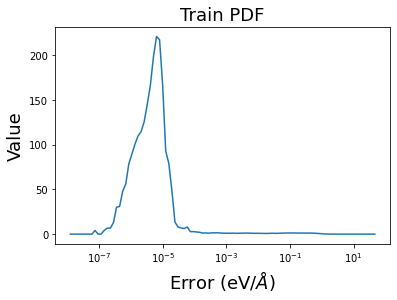

In [7]:
_ = plt.plot(estimator.bins[1:], estimator.pdfs.mean(axis=0))
_ = plt.xscale('log')
_ = plt.xlabel(r'Error (eV/$\AA$)', fontsize=18)
_ = plt.ylabel('Value', fontsize=18)
_ = plt.title('Train PDF', fontsize=18)

# Use estimator with pre-computed descriptors

In [8]:
query_descriptors = np.load('./descriptors_sample_215_GAP20.npy')
query_descriptors.shape

(170, 32)

In [9]:
query_pdfs = estimator(query_descriptors, topk=10)
query_pdfs.shape  # returns the predicted error PDF for each query atom

(170, 100)

In [10]:
# helper function for obtaining the expectation value of each PDF (handles log-spaced bins)
uq = estimator.predict_errors(query_descriptors, topk=10)
uq.shape

(170,)

# Use estimator within an ASE Wrapper

In [11]:
calc = NequIPUQWrapper.from_deployed_model(
    '../paper_data/deployed_GAP20.pth',
    uq_estimator=estimator
)  # ignore the warnings...

/usr/WS1/vita1/programs/nequip/nequip/scripts/deploy.py:138: UserWarning: Models deployed before v0.6.0 don't contain information about their default_dtype or model_dtype; assuming the old default of float32 for both, but this might not be right if you had explicitly set default_dtype=float64.
  warnings.warn(
/usr/WS1/vita1/programs/nequip/nequip/utils/_global_options.py:59: UserWarning: !! Upstream issues in PyTorch versions >1.11 have been seen to cause unusual performance degredations on some CUDA systems that become worse over time; see https://github.com/mir-group/nequip/discussions/311. At present we *strongly* recommend the use of PyTorch 1.11 if using CUDA devices; while using other versions if you observe this problem, an unexpected lack of this problem, or other strange behavior, please post in the linked GitHub issue.
  warnings.warn(
/usr/WS1/vita1/programs/nequip/nequip/utils/_global_options.py:70: UserWarning: Setting the GLOBAL value for jit fusion strategy to `[('DYNAM

In [12]:
atoms = read('./sample_215_GAP20.extxyz')

calc.calculate(  # handles descriptor extraction and UQ
    atoms,
    properties=['forces'],
    uq=True,
    topk=10,  # number of neighbors over which to estimate the uncertainty,
)

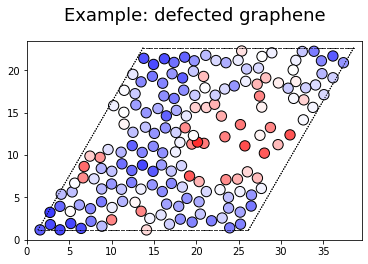

In [13]:
fig, ax = plt.subplots()
cmap = plt.get_cmap('bwr')

_ = plot_atoms(atoms, ax, radii=0.8, colors=cmap(calc.results['uq']))
_ = plt.title('Example: defected graphene', fontsize=18, pad=20)

# Save/load the estimator

In [14]:
estimator.save('./estimator_GAP20.faiss')

In [15]:
estimator = UQEstimator(
    pdfs,  # PDFs can be loaded separately from the indexer
    bins,
#     descriptors,  # descriptors are stored as part of the FAISS indexer
    load_index=True,
    index_load_path='./estimator_GAP20.faiss'
)

In [16]:
previous_uq = calc.results['uq'].copy()

calc.estimator = estimator
calc.calculate(atoms, properties=['forces'], uq=True, topk=10)

np.linalg.norm(previous_uq - calc.results['uq'])  # making sure they're the same as before

0.0

# Helper functions

In [17]:
from ltau_ff.utils import logs_to_pdfs

In [18]:
help(logs_to_pdfs)

Help on function logs_to_pdfs in module ltau_ff.utils:

logs_to_pdfs(logs, bins, nbins=None, range_limits=None, bin_spacing='log')
    Computes the PDF of errors for each sample using an ensemble of error trajectories.
    Modified from SO post:
    
    https://stackoverflow.com/questions/44152436/calculate-histograms-along-axis
    
    Args:        
        logs (list[np.ndarray]): a list of M arrays, where each element in the
            list is of size (T_m, N). T_m is the number of training epochs for
            the m-th model in the ensemble.
            
        bins (np.ndarray): array of bin edges. If not provided, must provide
        `nbins`, `range_limits`, and `bin_spacing`.
    
        nbins (int): the number of bins to use for computing the PDFs
        
        range_limits (tuple[float]): the upper/lower limits of the bins. If not
        provided, uses the min/max error from `logs`.
        
        bin_spacing (str): one of "log" or "linear". Default is "log".
   